In [112]:
import numpy as np
import numpy.random as npr
import math
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import natsort

import time
import sys
import os.path
import glob
import os

import matplotlib.pyplot as plt
from matplotlib import rc

In [113]:
PATH = '../data/era-discretizations/'
PATH_TO_VISUALS = '../../../thesis-visuals/'

In [114]:
def get_data(files):
    files = natsort.natsorted(glob.glob(files))
    dfs = [pd.read_csv(f) for f in files]
    filenames = [file.split('/')[-1][:-8] for file in files]
    for df, file in zip(dfs, filenames):
        df['file'] = file
    return pd.concat(dfs).reset_index(drop=True)

# lets look at 2 pms

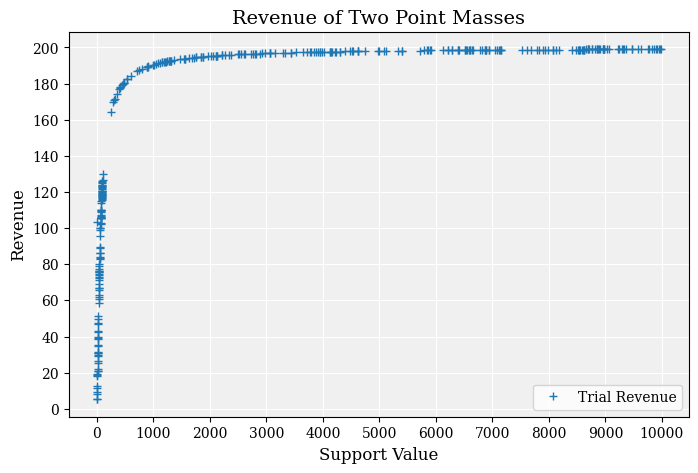

In [116]:
files = PATH+f'iterative-process/2-pms-test-*-res.csv'
df = get_data(files)
df.sort_values(by='sup_2')

plt.figure(figsize=(8,5))
plt.rc('font', family='serif')
plt.gca().set_facecolor('#f0f0f0')
plt.gca().grid(color='white')

plt.plot(df[df.sup_2 < 10_000].sup_2, df[df.sup_2 < 10_000].rev_100, '+', label='Trial Revenue')

plt.xticks(range(0,10_001, 1_000))
plt.yticks(range(0,201,20))

plt.xlabel('Support Value', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.title(f'Revenue of Two Point Masses', fontsize=14)
plt.legend()

# plt.savefig(PATH_TO_VISUALS+'re-two-pms.png', dpi=300, bbox_inches='tight')
plt.show()

# lets iterate one point mass at a time

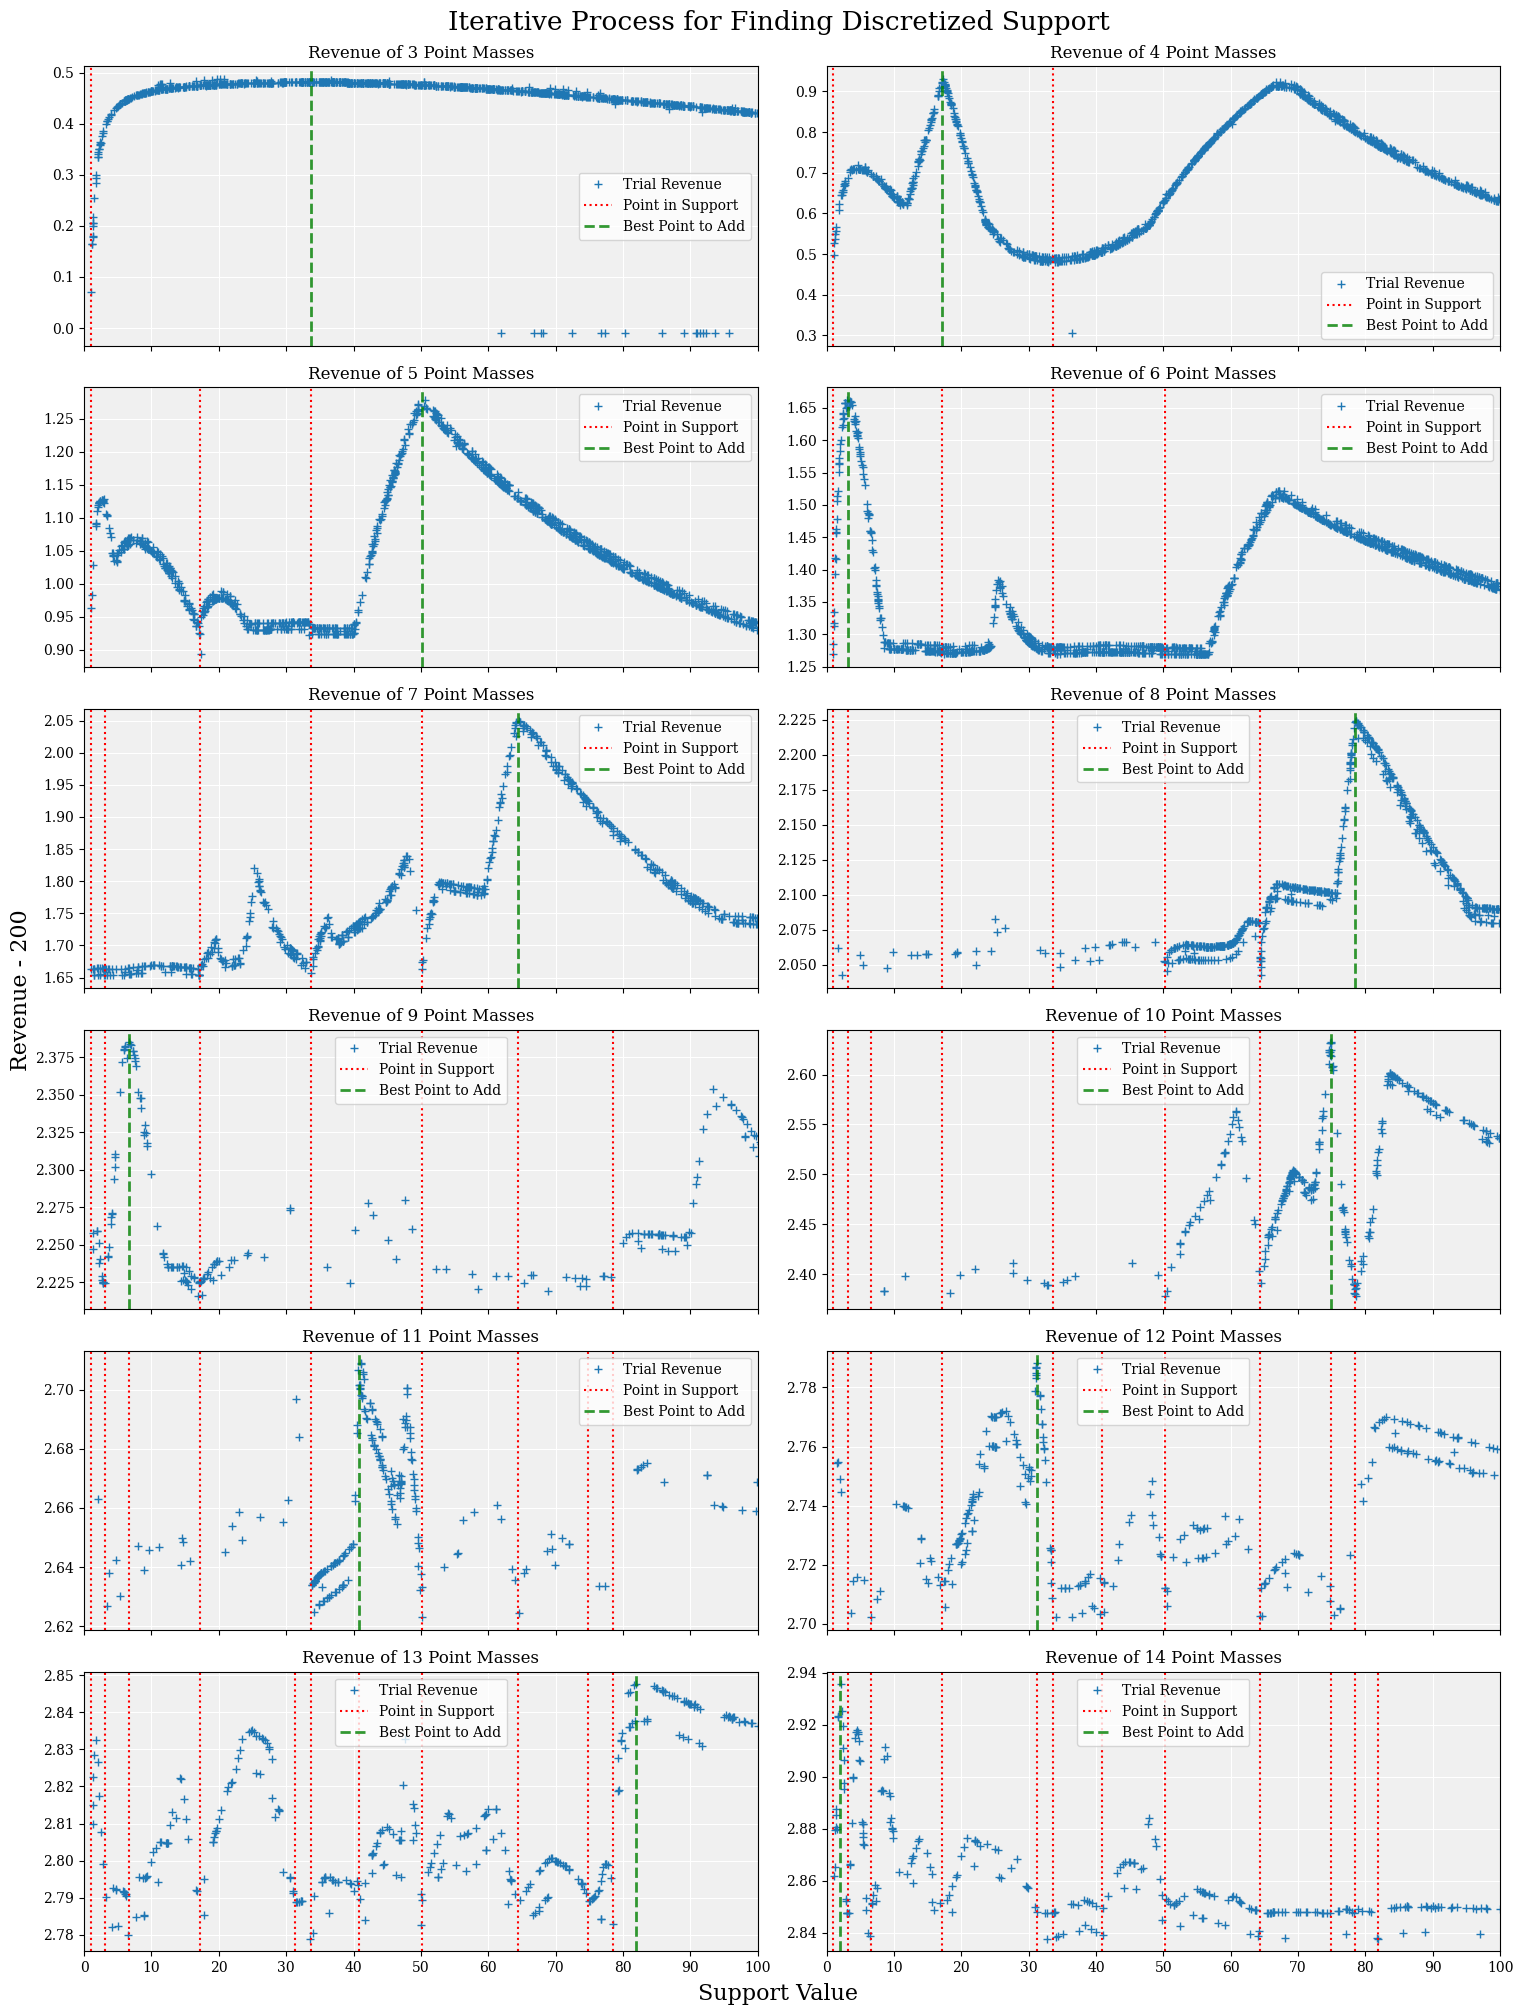

In [118]:
support = [1, 1_000_000, 33.6548, 17.1463, 50.1830, 3.1103, 64.4149, 78.5005, 6.6654, 74.8116, 40.8516, 31.2373, 81.8942, 1.9974]
sup_cols = [f'sup_{i+1}' for i in range(len(support))]
files = PATH+f'iterative-process/*-pms-test-*-res.csv'
df = get_data(files)
df['support_size'] = df.file.apply(lambda s: int(s.split('-')[0]))

fig, axs = plt.subplots(6, 2, figsize=(15, 20), sharex=True)
axs = axs.flatten()

plt.rc('font', family='serif')

best_rev_of_pms = {}

for i in range(3, len(support) + 1):
    temp = df[df.support_size == i]
    best_rev_of_pms[i] = temp.rev_100.max()

    axs[i-3].plot(temp[sup_cols[:i]].replace(support, np.nan).max(axis=1), temp.rev_100 - 200, '+', label='Trial Revenue')

    line_printed=False
    for point in support[:i-1]:
        if point != 1_000_000 and not line_printed:
            axs[i-3].axvline(x=point, linestyle=':', color='red', label='Point in Support')
            line_printed=True
        elif point != 1_000_000:
            axs[i-3].axvline(x=point, linestyle=':', color='red')
    axs[i-3].axvline(x=support[i-1], linestyle='--', color='green', linewidth=2, alpha=0.8, label='Best Point to Add')

    axs[i-3].set_facecolor('#f0f0f0')
    axs[i-3].grid(color='white')
    axs[i-3].set_title(f'Revenue of {i} Point Masses')
    axs[i-3].legend()
    axs[i-3].set_xlim(0, 100)
    axs[i-3].set_xticks(np.arange(0, 101, 10))

fig.text(0.5, -0.002, 'Support Value', ha='center', va='center', fontsize=16)
fig.text(-0.005, 0.5, 'Revenue - 200', ha='center', va='center', rotation='vertical', fontsize=16)
fig.suptitle('Iterative Process for Finding Discretized Support', fontsize=19, y=.99)
plt.tight_layout()

# plt.savefig(PATH_TO_VISUALS+'re-iterative-search-grid.png', bbox_inches='tight', dpi=300)
plt.show()



In [119]:
df[df.support_size == 14].sort_values(by='rev_100', ascending=False).head(5)

,trial,rev_100,sup_1,sup_2,file,sup_3,sup_4,sup_5,sup_6,sup_7,sup_8,sup_9,sup_10,sup_11,sup_12,sup_13,sup_14,support_size
12032,9.0,202.9383,1.0,1.9974,14-pms-test-2,3.1103,6.6654,17.1463,31.2373,33.6548,40.8516,50.183,64.4149,74.8116,78.5005,81.8942,1000000.0,14
11969,180.0,202.9354,1.0,2.1546,14-pms-test-1,3.1103,6.6654,17.1463,31.2373,33.6548,40.8516,50.183,64.4149,74.8116,78.5005,81.8942,1000000.0,14
11830,22.0,202.9252,1.0,2.3438,14-pms-test-1,3.1103,6.6654,17.1463,31.2373,33.6548,40.8516,50.183,64.4149,74.8116,78.5005,81.8942,1000000.0,14
12034,11.0,202.9231,1.0,1.7523,14-pms-test-2,3.1103,6.6654,17.1463,31.2373,33.6548,40.8516,50.183,64.4149,74.8116,78.5005,81.8942,1000000.0,14
12071,48.0,202.9228,1.0,1.7482,14-pms-test-2,3.1103,6.6654,17.1463,31.2373,33.6548,40.8516,50.183,64.4149,74.8116,78.5005,81.8942,1000000.0,14


[8.49006056e+01 7.43882663e-01 2.65693420e+00 6.65965499e-01
 6.46363871e-15 2.59949351e-02 7.25542196e+01] 0.0011484866857538521


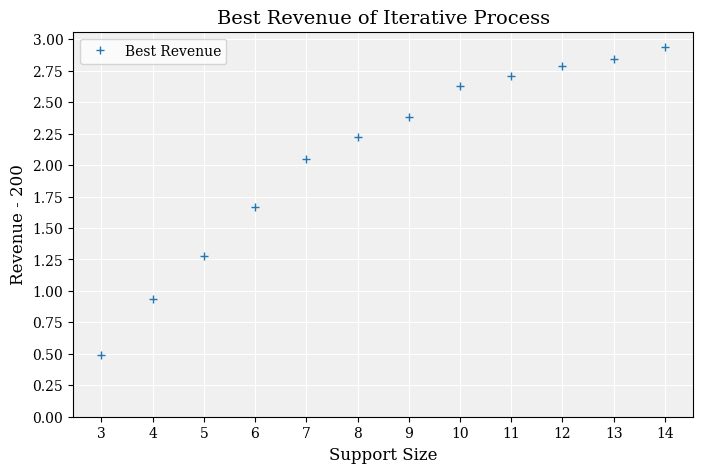

In [120]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d, e, f, g):
    return (a + b*np.exp(np.log(x))**2 + c*np.exp(np.log(x))**2) / (d + e*np.exp(np.log(x)) + f*np.exp(np.log(x))**2) + g

x = list(range(2,13))
y = list(best_rev_of_pms.values())[:-1]

popt, pcov = curve_fit(func, x, y, bounds=(0, np.inf))
# Calculate the mean squared error of the fit
y_fit = func(x, *popt)
residuals = y - y_fit
mse = np.mean(residuals**2)

print(popt, mse)

plt.figure(figsize=(8,5))
plt.rc('font', family='serif')
plt.gca().set_facecolor('#f0f0f0')
plt.gca().grid(color='white')

plt.plot(best_rev_of_pms.keys(), np.array(list(best_rev_of_pms.values())) - 200, '+', label='Best Revenue')
ticks = list(range(2, 15))
# plt.plot(ticks, [func(t, *popt) for t in ticks], 'b', label='a*log(n)+b')

plt.xticks(range(3,15))
plt.yticks(np.array(range(0, 13))/4)

plt.xlabel('Support Size', fontsize=12)
plt.ylabel('Revenue - 200', fontsize=12)
plt.title(f'Best Revenue of Iterative Process', fontsize=14)
plt.legend()
# plt.savefig(PATH_TO_VISUALS+'re-best-rev-vs-support-size.png', dpi=300, bbox_inches='tight')
plt.show()

## lets see if transitivity holds

In [215]:
'''support = [1, 1_000_000, 33.6548, 17.1463, 50.1830, 3.1103, 64.4149, 78.5005, 6.6654, 74.8116, 40.8516, 31.2373]
sup_cols = [f'sup_{i+1}' for i in range(len(support))]
files = PATH+f'pms/7*-res.csv'
df = get_data(files)
df['support_size'] = df.file.apply(lambda s: int(s.split('-')[0]))

fig, axs = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
axs = axs.flatten()

pms = 7

for i, f in enumerate(sorted(df.file.unique())[1:]):
    temp = df[df.file == f]
    axs[i].plot(temp[sup_cols[:pms]].replace(support, np.nan).max(axis=1), temp.rev_100, '+', label='Trial Revenue')

    missing = list(set(support[:7]) - set(temp.iloc[0].values))[0]

    line_printed=False
    #if i == 4: break
    for point in support[:pms]:
        if point == missing:
            axs[i].axvline(x=point, linestyle='--', color='green', linewidth=2, label='Missing point')
        elif point != 1_000_000 and not line_printed and point != missing:
            axs[i].axvline(x=point, linestyle=':', color='red', label='Point in support')
            line_printed=True
        elif point != 1_000_000:
            axs[i].axvline(x=point, linestyle=':', color='red')

    axs[i].set_facecolor('#f0f0f0')
    axs[i].grid(color='white')
    #axs[i].set_title(f'{f} missing {missing}')
    axs[i].legend()
    axs[i].set_xlim(0, 100)

axs[-1].axis('off')
fig.text(0.5, -0.005, 'Support Value', ha='center', va='center', fontsize=14)
fig.text(-0.003, 0.5, 'Revenue', ha='center', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Transitivity of Iteratively-Added Supports', fontsize=18)
plt.tight_layout()

# plt.savefig(PATH_TO_VISUALS+'re-iterative-transitivity.png', bbox_inches='tight', dpi=300)

plt.show()'''

"support = [1, 1_000_000, 33.6548, 17.1463, 50.1830, 3.1103, 64.4149, 78.5005, 6.6654, 74.8116, 40.8516, 31.2373]\nsup_cols = [f'sup_{i+1}' for i in range(len(support))]\nfiles = PATH+f'pms/7*-res.csv'\ndf = get_data(files)\ndf['support_size'] = df.file.apply(lambda s: int(s.split('-')[0]))\n\nfig, axs = plt.subplots(3, 2, figsize=(15, 12), sharex=True)\naxs = axs.flatten()\n\npms = 7\n\nfor i, f in enumerate(sorted(df.file.unique())[1:]):\n    temp = df[df.file == f]\n    axs[i].plot(temp[sup_cols[:pms]].replace(support, np.nan).max(axis=1), temp.rev_100, '+', label='Trial Revenue')\n\n    missing = list(set(support[:7]) - set(temp.iloc[0].values))[0]\n\n    line_printed=False\n    #if i == 4: break\n    for point in support[:pms]:\n        if point == missing:\n            axs[i].axvline(x=point, linestyle='--', color='green', linewidth=2, label='Missing point')\n        elif point != 1_000_000 and not line_printed and point != missing:\n            axs[i].axvline(x=point, linestyle=

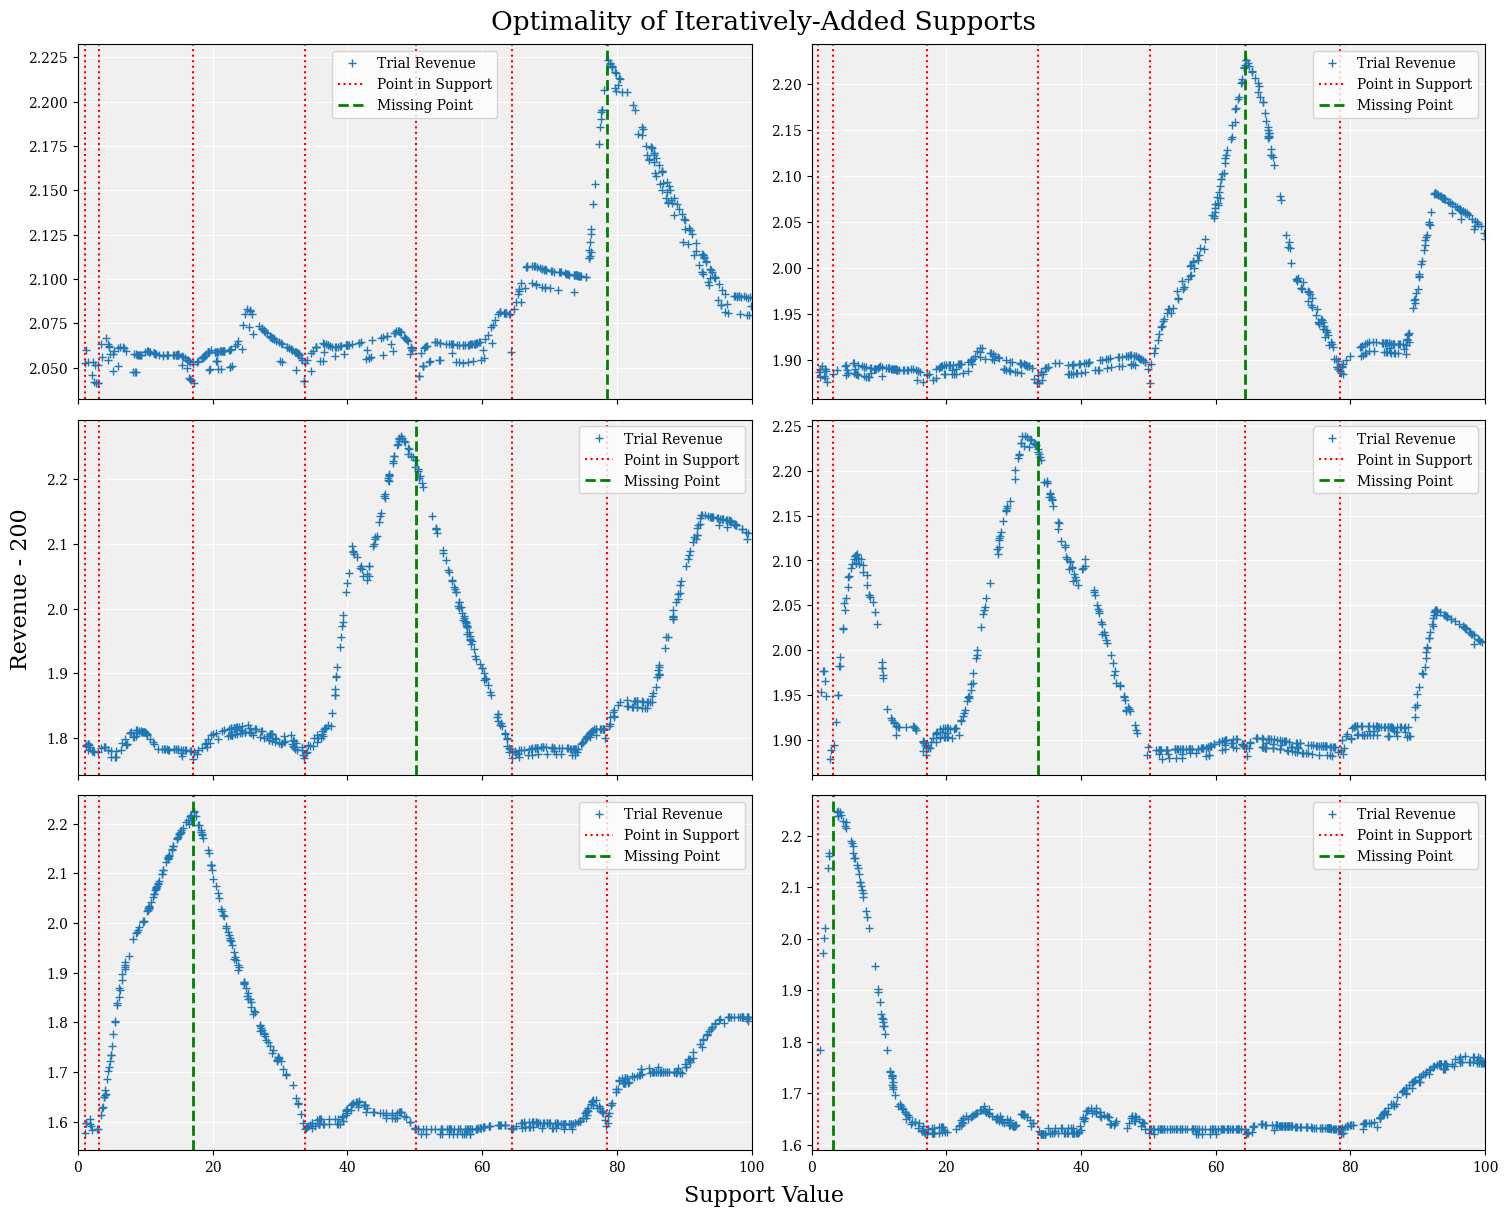

In [95]:
pms = 8

support = [1, 1_000_000, 33.6548, 17.1463, 50.1830, 3.1103, 64.4149, 78.5005, 6.6654, 74.8116, 40.8516, 31.2373, 81.8942, 1.9974]
sup_cols = [f'sup_{i+1}' for i in range(len(support))]
files = PATH+f'pms/{pms}-pms-vary*-res.csv'
df = get_data(files)
df['support_size'] = df.file.apply(lambda s: int(s.split('-')[0]))

fig, axs = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
axs = axs.flatten()


for i, f in enumerate(sorted(df.file.unique())[0:]):
    temp = df[df.file == f]
    axs[i].plot(temp[sup_cols[:pms]].replace(support, np.nan).max(axis=1), temp.rev_100 - 200, '+', label='Trial Revenue')

    missing = list(set(support[:pms]) - set(temp.iloc[0].values))[0]

    line_printed=False
    #if i == 4: break
    for point in support[:pms]:
        if point == missing:
            axs[i].axvline(x=point, linestyle='--', color='green', linewidth=2, label='Missing Point')
        elif point != 1_000_000 and not line_printed and point != missing:
            axs[i].axvline(x=point, linestyle=':', color='red', label='Point in Support')
            line_printed=True
        elif point != 1_000_000:
            axs[i].axvline(x=point, linestyle=':', color='red')

    axs[i].set_facecolor('#f0f0f0')
    axs[i].grid(color='white')
    #axs[i].set_title(f'{f} missing {missing}')
    axs[i].legend()
    axs[i].set_xlim(0, 100)

fig.text(0.5, -0.005, 'Support Value', ha='center', va='center', fontsize=16)
fig.text(0.005, 0.5, 'Revenue - 200', ha='center', va='center', rotation='vertical', fontsize=16)
fig.suptitle('Optimality of Iteratively-Added Supports', fontsize=19, y=0.983)

plt.tight_layout()

# plt.savefig(PATH_TO_VISUALS+'re-iterative-transitivity.png', bbox_inches='tight', dpi=300)

plt.show()

# now lets do some randomized trials

testsmedium2 red
testsmedium3 blue
testsmedium5 green
testsmedium6 orange
testsmedium1 yellow
testsmedium7 black
testsmedium4 purple
test4 red
test2 blue
test3 green
test1 orange
test5 yellow
test6 black
test8 purple
test7 red
test0 blue
testsmall0 green
testsmall1 orange
testsmall2 yellow
testsmall3 black
testsmall4 purple
testsmall5 red
testsmall6 blue
testsmall7 green
testsmall8 orange
testsmall9 yellow
testsmall10 black
testsmall11 purple


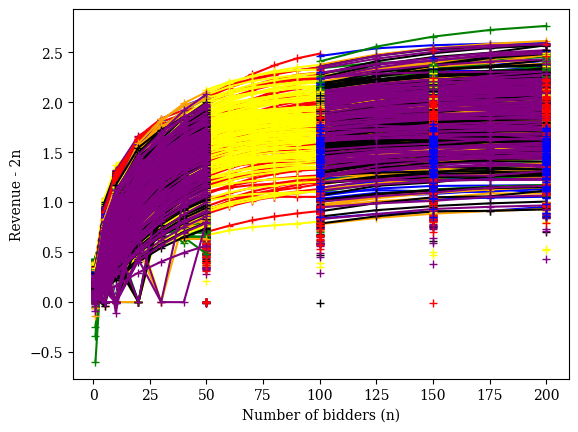

"for col in df_revs.columns:\n    n = int(col.split('_')[-1])\n    x = [n] * df.shape[0]\n    y = df[col] - 2*n\n    plt.scatter(x,y, marker='+')"

In [45]:
files = PATH+'moving-bulk-first-take/test*-res.csv'
bmps = np.array([1,5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175, 200])
rev_cols = [f'rev_{bmp}' for bmp in bmps]
df = get_data(files)
df = df.sort_values(by='rev_100', ascending=False)
df = df.reset_index(drop=True)
df_revs = df.set_index('file')[rev_cols] - 2*bmps
df_revs.columns = bmps

# df_revs.T.plot(color='blue')

colors = ['red', 'blue', 'green', 'orange', 'yellow', 'black', 'purple'] * 7
num_files = len(df_revs.T.columns.unique())

for file, color in zip(df_revs.T.columns.unique(), colors[:num_files]):
    plt.plot(df_revs.T[[file]], color=color, label=file, marker='+')
    print(file, color)

'''xticks_pos = rev_cols  # Specify the positions of the xticks
xticks_labels = bmps  # Specify the labels of the xticks
plt.xticks(xticks_pos, xticks_labels)'''

plt.xlabel('Number of bidders (n)')
plt.ylabel('Revenue - 2n')
plt.show()

'''for col in df_revs.columns:
    n = int(col.split('_')[-1])
    x = [n] * df.shape[0]
    y = df[col] - 2*n
    plt.scatter(x,y, marker='+')'''

/var/folders/jf/z2mj2s1163z1wn19j7pvcdx40000gn/T/ipykernel_35434/3718080320.py:2: RuntimeWarning: divide by zero encountered in log
  return a * np.log(x) + b


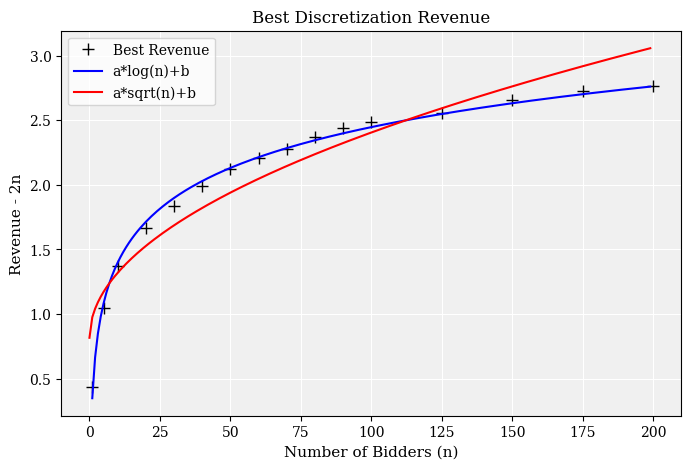

[0.45574437 0.34845055] 0.0014250570577018752
[0.15890362 0.81639576] 0.03960466161257327


In [46]:
def log_func(x, a, b):
    return a * np.log(x) + b

def sqrt_func(x, a, b):
    return a * np.sqrt(x) + b

x = bmps
y = df_revs.max(axis=0).values

popt_log, pcov_log = curve_fit(log_func, x, y)
popt_sqrt, pcov_sqrt = curve_fit(sqrt_func, x, y)

# Calculate the mean squared error of the fit
y_fit = log_func(x, *popt_log)
residuals = y - y_fit
mse_log = np.mean(residuals**2)

y_fit = sqrt_func(x, *popt_sqrt)
residuals = y - y_fit
mse_sqrt = np.mean(residuals**2)

plt.figure(figsize=(8,5))
plt.plot(x, y, '+', markersize=8, color='black', label='Best Revenue')
ticks = list(range(200))
plt.plot(ticks, [log_func(t, *popt_log) for t in ticks], 'b', label='a*log(n)+b')
plt.plot(ticks, [sqrt_func(t, *popt_sqrt) for t in ticks], 'r', label='a*sqrt(n)+b')
plt.gca().set_facecolor('#f0f0f0')
plt.gca().grid(color='white')
plt.xlabel('Number of Bidders (n)', fontsize=11)
plt.ylabel('Revenue - 2n', fontsize=11)
plt.title(f'Best Discretization Revenue')
plt.legend()

#plt.savefig(PATH_TO_VISUALS+'re-era-best-discretization-graph.png', dpi=300)
plt.show()

print(popt_log, mse_log)
print(popt_sqrt, mse_sqrt)

In [47]:
sup_cols = [f'sup_{i}' for i in range(1,11)]
best_trial_by_bmp =  {}
for bmp in bmps:
    best_trial_by_bmp[f'rev_{bmp}'] = df.sort_values(by=f'rev_{bmp}', ascending=False)[sup_cols].iloc[0]

best_trials = pd.DataFrame(best_trial_by_bmp).T
best_trials = best_trials.drop_duplicates()
best_trials

,sup_1,sup_2,sup_3,sup_4,sup_5,sup_6,sup_7,sup_8,sup_9,sup_10
rev_1,1.0,1.4204,1.8722,2.1582,2.5695,3.0167,3.6447,3.7873,3.9190,1000000.0
rev_5,1.0,1.4068,2.4398,3.2581,4.1063,6.3128,7.1982,8.4104,9.4542,1000000.0
rev_10,1.0,1.9439,3.1859,4.9313,6.9610,8.7124,11.1121,12.3501,14.2800,1000000.0
rev_20,1.0,2.1037,4.0793,6.5405,11.0769,16.5213,18.6373,20.5460,21.7550,1000000.0
rev_30,1.0,3.9274,6.8019,10.3567,14.7016,18.8409,22.3314,26.9352,33.9787,1000000.0
rev_40,1.0,1.6071,4.9962,15.3899,23.8099,29.5197,40.4729,52.3068,56.0337,1000000.0
rev_50,1.0,2.5950,10.3757,18.7739,25.5666,28.7084,38.8223,49.1948,59.9075,1000000.0
rev_70,1.0,3.6521,9.3312,13.3877,34.9461,48.8991,71.8864,77.9958,82.2960,1000000.0
rev_125,1.0,2.6331,7.3263,20.4229,56.9821,89.3596,103.7303,107.0498,119.2869,1000000.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


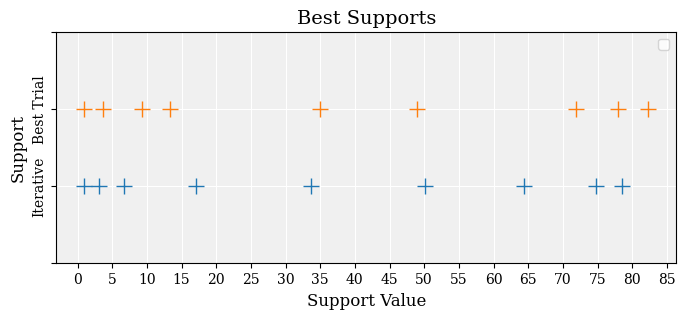

In [51]:
iterative_100_sup = np.sort(support[:10])
best_trial_100_sup = best_trials.loc['rev_70'].values

iterative_100_sup = iterative_100_sup[:-1]
best_trial_100_sup = best_trial_100_sup[:-1]


plt.figure(figsize=(8,3))

plt.plot(iterative_100_sup, [1 for _ in range(9)], '+', markersize=12)
plt.plot(best_trial_100_sup, [2 for _ in range(9)], '+', markersize=12)

plt.ylim(0,3)
plt.xticks(list(range(0,90,5)))
plt.yticks([0, 1, 2, 3], ['', 'Iterative', 'Best Trial', ''], rotation=90, verticalalignment='center')

plt.gca().set_facecolor('#f0f0f0')
plt.gca().grid(color='white')
plt.xlabel('Support Value', fontsize=12)
plt.ylabel('Support', fontsize=12)
plt.title(f'Best Supports', fontsize=14)
plt.legend()

# plt.savefig(PATH_TO_VISUALS+'re-era-iterative-vs-trial-support.png', dpi=300, bbox_inches='tight')
plt.show()


## final graph

/var/folders/jf/z2mj2s1163z1wn19j7pvcdx40000gn/T/ipykernel_35434/1582911548.py:9: RuntimeWarning: divide by zero encountered in log
  return a * np.log(x) + b


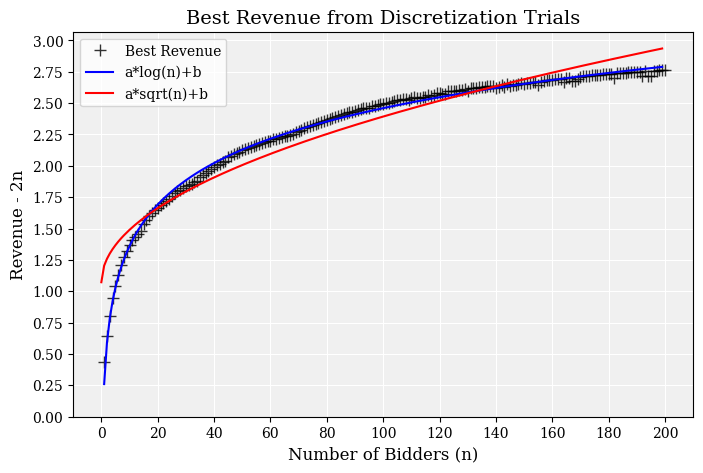

[0.47773613 0.26009847] 0.0008067724347151975
[0.13209086 1.07218466] 0.016416034905823176


In [43]:
files = PATH + 'filling-in-bmps/*-res.csv'
df = get_data(files)
rev_cols = df.columns[df.columns.str.contains('rev')]
bmps = np.array([int(s.split('_')[-1]) for s in rev_cols])
best_trial_revs = df[rev_cols].max(axis=0) - 2*bmps


def log_func(x, a, b):
    return a * np.log(x) + b
def sqrt_func(x, a, b):
    return a * np.sqrt(x) + b

x = bmps
y = best_trial_revs

popt_log, pcov_log = curve_fit(log_func, x, y)
popt_sqrt, pcov_sqrt = curve_fit(sqrt_func, x, y)

# Calculate the mean squared error of the fit
y_fit = log_func(x, *popt_log)
residuals = y - y_fit
mse_log = np.mean(residuals**2)

y_fit = sqrt_func(x, *popt_sqrt)
residuals = y - y_fit
mse_sqrt = np.mean(residuals**2)

plt.figure(figsize=(8,5))
plt.plot(x[::1], y[::1], '+', markersize=8, color='black', alpha=0.8, label='Best Revenue')
ticks = list(range(200))

plt.plot(ticks, [log_func(t, *popt_log) for t in ticks], 'b', label='a*log(n)+b')
plt.plot(ticks, [sqrt_func(t, *popt_sqrt) for t in ticks], 'r', label='a*sqrt(n)+b')
plt.gca().set_facecolor('#f0f0f0')
plt.gca().grid(color='white')
plt.xlabel('Number of Bidders (n)', fontsize=12)
plt.ylabel('Revenue - 2n', fontsize=12)
plt.title(f'Best Revenue from Discretization Trials', fontsize=14)
plt.legend()

plt.xticks(list(range(0, 201, 20)))
plt.yticks(np.array(range(0,13, 1))/4)

# plt.savefig(PATH_TO_VISUALS+'re-era-best-discretization-graph.png', dpi=300, bbox_inches='tight')
plt.show()

print(popt_log, mse_log)
print(popt_sqrt, mse_sqrt)

# 3d stuff for fun

In [16]:
df[df.sup_2 > 80]

,trial,rev_100,sup_1,sup_2,sup_3,sup_4,file
7,8,200.4581,1.0,82.5657,99.8939,1000000.0,4-pms-test-1
13,14,200.4628,1.0,81.6761,94.0931,1000000.0,4-pms-test-1
50,51,199.9902,1.0,92.8621,96.9752,1000000.0,4-pms-test-1
76,77,200.4551,1.0,81.8133,96.1068,1000000.0,4-pms-test-1
143,144,200.4508,1.0,80.1536,88.9306,1000000.0,4-pms-test-1
...,...,...,...,...,...,...,...
19940,9941,200.3862,1.0,87.5752,95.3117,1000000.0,4-pms-test-2
19953,9954,200.4513,1.0,85.9890,92.6830,1000000.0,4-pms-test-2
19959,9960,200.4444,1.0,86.2873,97.7427,1000000.0,4-pms-test-2
19982,9983,200.4488,1.0,86.5373,89.9689,1000000.0,4-pms-test-2


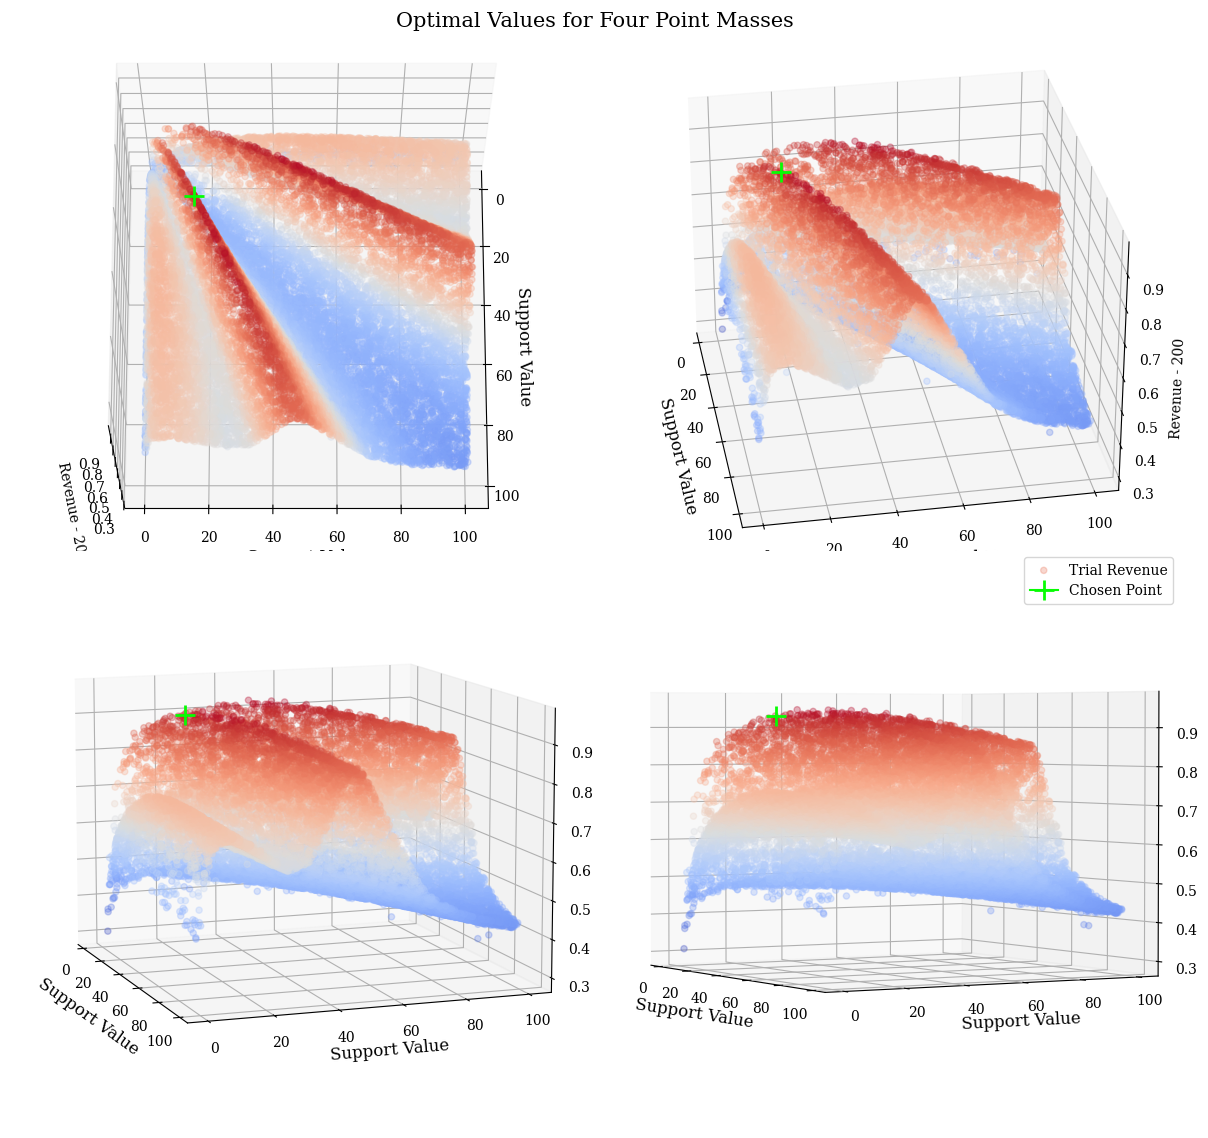

In [172]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3D, Line3DCollection


files = PATH + 'iterative-process/3d-4pms/*.csv'
df = get_data(files)
df = df[df.rev_100 > 200.2]

mask = np.random.choice([True, False], size=len(df))
df.loc[mask, 'sup_2'], df.loc[mask, 'sup_3'] = df.loc[mask, 'sup_3'], df.loc[mask, 'sup_2']

x = df['sup_2']
y = df['sup_3']
z = df['rev_100'] - 200

angles = [(70, 0), (30, -10), (10, -20), (2, -30)]

# Create a figure with subplots for each combination of elevation and azimuth values
fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# Iterate through each subplot and set the view using the corresponding elevation and azimuth values
for i, (elev, azim) in enumerate(angles):
    ax = axes[i]
    
    scatter = ax.scatter(x, y, z, c=z, cmap='coolwarm', alpha=0.3, label='Trial Revenue')

    # Add a thick green vertical dotted line at x=30, y=15
    #z_range = np.linspace(0, z.max() + 0.5, 100)
    #ax.plot([30] * 100, [15] * 100, z_range, 'g', linewidth=4, zorder=-1, label='Point from Iterative Process')
    #ax.scatter(33.6548, 17.1463, 0.9332, c='green', s=300, marker='+', markeredgewidth=3)
    ax.plot(33.6548, 17.1463, 0.93, marker='+', color='#07fc03', markersize=15, mew=2, mec='#07fc03', zorder=10, label='Chosen Point')



    ax.set_xlabel('Support Value', fontsize=12)
    ax.set_ylabel('Support Value', fontsize=12)
    ax.set_zlabel('Revenue - 200')
    ax.view_init(elev=elev, azim=azim)


# cbar = fig.colorbar(scatter, ax=ax, pad=0.2)

# Adjust the spacing between subplots and display the figure
fig.suptitle('Optimal Values for Four Point Masses', fontsize=15, y=0.95)
fig.subplots_adjust(wspace=-0.3, hspace=-0.5)
# fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9, hspace=0.2)
plt.tight_layout()
plt.legend()

# plt.savefig(PATH_TO_VISUALS+'ap-era-3d-4pms.png', dpi=150, bbox_inches='tight')
plt.show()


In [32]:
df.sort_values(by='rev_100', ascending=False).head(20)

,trial,rev_100,sup_1,sup_2,sup_3,sup_4,file
6488,6489,200.9466,1.0,21.3301,41.9039,1000000.0,4-pms-test-1
5959,5960,200.9464,1.0,20.7042,40.4076,1000000.0,4-pms-test-1
2961,2962,200.9453,1.0,48.3846,24.4106,1000000.0,4-pms-test-1
4948,4949,200.9431,1.0,26.3293,52.0531,1000000.0,4-pms-test-1
4659,4660,200.9431,1.0,26.4784,52.2566,1000000.0,4-pms-test-1
7779,7780,200.9419,1.0,23.1693,46.0110,1000000.0,4-pms-test-1
18656,8657,200.9389,1.0,55.7268,27.7404,1000000.0,4-pms-test-2
14898,4899,200.9374,1.0,58.0837,29.4856,1000000.0,4-pms-test-2
194,195,200.9373,1.0,22.7369,44.4791,1000000.0,4-pms-test-1
13090,3091,200.9372,1.0,22.3938,43.8332,1000000.0,4-pms-test-2
